In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [2]:
import torchvision
import glob
from matplotlib import pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import os.path as osp
import numpy as np
import torch
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16
from torch.optim import lr_scheduler
import torch.optim as optim
import time
import copy
import torch.nn as nn
import PIL
import torch.nn.functional as Func
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
#Split the dataset into Train, Validation and Test set
total_image = sorted(glob.glob('drive/My Drive/CSCI-677-HW5/data_semantics/training/image_2/*'))
total_label = sorted(glob.glob('drive/My Drive/CSCI-677-HW5/data_semantics/training/semantic/*'))
image_train, image_rest, label_train, label_rest = train_test_split(total_image, total_label, test_size=0.30, random_state=42)
image_test, image_val, label_test, label_val = train_test_split(image_rest, label_rest, test_size=0.50, random_state=42)


In [4]:
class semantic_dataset_train(Dataset):
    def __init__(self, split = 'test', transform = None):
        self.void_labels = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_labels = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
        self.ignore_index = 250
        self.class_map = dict(zip(self.valid_labels, range(19)))
        self.split = split
        
        self.transform = transform
        
        self.img_list = image_train
        self.mask_list = label_train
        
    def __len__(self):
        return(len(self.img_list))
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_list[idx])
        img = cv2.resize(img, (1242, 376))
        mask = None
        if self.split == 'train':
            mask = cv2.imread(self.mask_list[idx], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (512, 256), interpolation=cv2.INTER_NEAREST)
            #mask = self.encode_segmap(mask)
            assert(mask.shape == (256, 512))
        
        if self.transform:
            img = self.transform(img)
            assert(img.shape == (3, 256, 512))
        else :
            assert(img.shape == (256, 512, 3))
        
        if self.split == 'train':
            return img, mask
        else :
            return img
    

class semantic_dataset_validation(Dataset):
    def __init__(self, split = 'test', transform = None):
        self.void_labels = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_labels = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
        self.ignore_index = 250
        self.class_map = dict(zip(self.valid_labels, range(19)))
        self.split = split
        
        self.transform = transform
        
        self.img_list = image_val
        self.mask_list = label_val
        
    def __len__(self):
        return(len(self.img_list))
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_list[idx])
        img = cv2.resize(img, (1242, 376))
        mask = None
        if self.split == 'train':
            mask = cv2.imread(self.mask_list[idx], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (512, 256), interpolation=cv2.INTER_NEAREST)
            #mask = self.encode_segmap(mask)
            assert(mask.shape == (256, 512))
        
        if self.transform:
            img = self.transform(img)
            assert(img.shape == (3, 256, 512))
        else :
            assert(img.shape == (256, 512, 3))
        
        if self.split == 'train':
            return img, mask
        else :
            return img
  

class semantic_dataset_test(Dataset):
    def __init__(self, split = 'test', transform = None):
        self.void_labels = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_labels = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
        self.ignore_index = 250
        self.class_map = dict(zip(self.valid_labels, range(19)))
        self.split = split
        
        self.transform = transform
        
        self.img_list = image_test
        self.mask_list = label_test
        
    def __len__(self):
        return(len(self.img_list))
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_list[idx])
        img = cv2.resize(img, (1242, 376))
        mask = None
        if self.split == 'train':
            mask = cv2.imread(self.mask_list[idx], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (512, 256), interpolation=cv2.INTER_NEAREST)
            #mask = self.encode_segmap(mask)
            assert(mask.shape == (256, 512))
        
        if self.transform:
            img = self.transform(img)
            assert(img.shape == (3, 256, 512))
        else :
            assert(img.shape == (256, 512, 3))
        
        if self.split == 'train':
            return img, mask
        else :
            return img
    

transformation = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((256,512),interpolation=PIL.Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.35675976, 0.37380189, 0.3764753], std = [0.32064945, 0.32098866, 0.32325324])
        ])
trainset = semantic_dataset_train(split = 'train', transform = transformation)
validationset = semantic_dataset_validation(split = 'train', transform = transformation)
testset = semantic_dataset_test(split = 'train', transform = transformation)

trainImages = DataLoader(trainset, batch_size = 5, shuffle = True)
valImages = DataLoader(validationset, batch_size = 5, shuffle = True)
testImages = DataLoader(testset, batch_size = 1, shuffle = True)


In [ ]:
#FC32 architecture
vgg16_mod = vgg16(pretrained=True)
for param in vgg16_mod.features.parameters():
  param.requires_grad = False
class FCN32(nn.Module):
  def __init__(self):
    super(FCN32, self).__init__()
    self.features = vgg16_mod.features
    self.classifier = nn.Sequential(
      nn.Conv2d(512, 4096, 7),
      nn.ReLU(inplace=True),
      nn.Dropout2d(),
      nn.Conv2d(4096, 4096, 1),
      nn.ReLU(inplace=True),
      nn.Dropout2d(),
      nn.Conv2d(4096, 35, 1),
      nn.ConvTranspose2d(35, 35, 224, stride=32)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

fcn = FCN32()
print(fcn)
input = torch.randn(5,3,256,512)
output = fcn(input)
print(output.shape)

In [5]:
#FC16 architecture
vgg16_mod = vgg16(pretrained=True)
for param in vgg16_mod.features.parameters():
  param.requires_grad = False
class FCN16(nn.Module):
  def __init__(self):
    super(FCN16, self).__init__()
    self.features = vgg16_mod.features
    self.classifier = nn.Sequential(
      nn.Conv2d(512, 4096, 7),
      nn.ReLU(inplace=True),
      nn.Conv2d(4096, 4096, 1),
      nn.ReLU(inplace=True),
      nn.Conv2d(4096, 35, 1)
    )
    self.score_pool4 = nn.Conv2d(512, 35, 1)
    self.upscore2 = nn.ConvTranspose2d(35, 35, 14, stride=2, bias=False)
    self.upscore16 = nn.ConvTranspose2d(35, 35, 16, stride=16, bias=False)

  def forward(self, x):
    pool4 = self.features[:-7](x)
    pool5 = self.features[-7:](pool4)
    pool5_upscored = self.upscore2(self.classifier(pool5))
    pool4_scored = self.score_pool4(pool4)
    combined = pool4_scored + pool5_upscored
    res = self.upscore16(combined)
    return res

fcn16 = FCN16()
print(fcn16)
input = torch.randn(5,3,256,512)
output = fcn16(input)
print(output.shape)

FCN16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [6]:
#Do not use
def training(fcn, criterion, optimizer,num_epochs):

  val_loss = []
  train_loss = []
  for epoch in range(num_epochs):
    fcn.train()
    val_running_loss = 0
    train_running_loss = 0
    fcn16.train()
    for i, trainData in enumerate(trainImages, 0):
      imgs, labels = trainData
      labels = labels.type(torch.LongTensor)
      #set the gradient to zero
      optimizer.zero_grad()
      outputs = fcn(imgs)
      loss = criterion(outputs, labels)
      loss.backward()
      train_running_loss += loss.item()
      optimizer.step()

    train_loss.append(train_running_loss)
    fcn16.eval()
    with torch.no_grad():
      for k, dat1 in enumerate(valImages):
      # Get image, label pair
        inputs1, labels1 = dat1
        labels1 = labels1.type(torch.LongTensor)
      # Predicting segmentation for val inputs
        outputs1 = fcn(inputs1)

        # Compute CE loss and aggregate it
        loss1 = criterion(outputs1, labels1)
        val_running_loss += loss1.item()

    val_loss.append(val_running_loss)
    print("Epochs: ", epoch, "Training Loss: ", train_running_loss, "val_running_loss: ", val_running_loss)
  return train_loss, val_loss

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(fcn16.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)
train_loss, val_loss = training(fcn16, criterion, optimizer, num_epochs=40)
torch.save(fcn16, 'drive/My Drive/CSCI-677-HW5/data_semantics/ModelFCN16_Adam_dropout.pt')

Epochs:  0 Training Loss:  59.28895115852356 val_running_loss:  8.553364157676697
Epochs:  1 Training Loss:  37.511099100112915 val_running_loss:  6.691580533981323
Epochs:  2 Training Loss:  30.72277069091797 val_running_loss:  5.295842289924622
Epochs:  3 Training Loss:  25.50015300512314 val_running_loss:  4.857889413833618
Epochs:  4 Training Loss:  23.424445688724518 val_running_loss:  4.323221564292908
Epochs:  5 Training Loss:  21.01056444644928 val_running_loss:  4.19649475812912
Epochs:  6 Training Loss:  19.65706741809845 val_running_loss:  3.9795762300491333
Epochs:  7 Training Loss:  18.750891357660294 val_running_loss:  3.966620981693268
Epochs:  8 Training Loss:  17.704172015190125 val_running_loss:  3.6421911120414734
Epochs:  9 Training Loss:  17.79672572016716 val_running_loss:  3.6277881860733032
Epochs:  10 Training Loss:  16.8015516102314 val_running_loss:  3.531625360250473
Epochs:  11 Training Loss:  15.630626678466797 val_running_loss:  3.347768396139145
Epochs: 

In [ ]:
#torch.save(fcn, 'drive/My Drive/CSCI677-Homeworks/data_semantics/Model_3_val_SGD.pt')

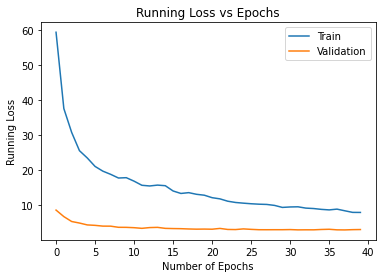

In [7]:
#Plotting Running loss vs Epochs
epochList = [i for i in range(0, 40)]
plt.plot(epochList, [x for x in train_loss], label = "Train")
plt.plot(epochList, [y for y in val_loss], label = "Validation")

plt.xlabel('Number of Epochs')
plt.ylabel('Running Loss')
plt.title('Running Loss vs Epochs')
plt.legend()
plt.show()

In [8]:
#Calculating IoU and mean IoU
def get_mean_iou(conf_mat, multiplier=1.0):
  cm = conf_mat.copy()
  np.fill_diagonal(cm, np.diag(cm) * multiplier)
  inter = np.diag(cm)
  gt_set = cm.sum(axis=1)
  pred_set = cm.sum(axis=0)
  union_set =  gt_set + pred_set - inter
  iou = inter.astype(float) / union_set
  mean_iou = np.nanmean(iou)
  return mean_iou
  
overall_conf_mat = np.zeros((35, 35))
with torch.no_grad():
  for k, dat1 in enumerate(testImages):
    # Get image, label pair
    inputs1, labels1 = dat1


    # Predicting segmentation for val inputs
    outputs1 = fcn16(inputs1)

    preds = torch.argmax(outputs1, dim=1).detach().numpy()
    gt = labels1.detach().numpy()

    # Compute confusion matrix
    conf_mat = confusion_matrix(y_pred=preds.flatten(), y_true=gt.flatten(), labels=list(range(35)))
    overall_conf_mat += conf_mat

print('DICE score: {}'.format(np.round(get_mean_iou(conf_mat=overall_conf_mat ,multiplier=2.0), 2)))
print('Mean IOU score: {}'.format(np.round(get_mean_iou(conf_mat=overall_conf_mat), 2)))

DICE score: 0.37
Mean IOU score: 0.28


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [10]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

Test set Number:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.2994560619263632
Dice:  0.35667136170434527


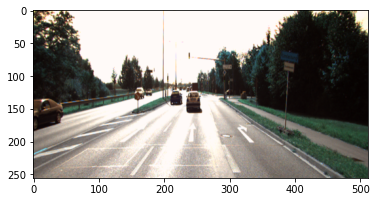

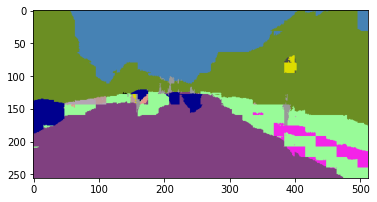

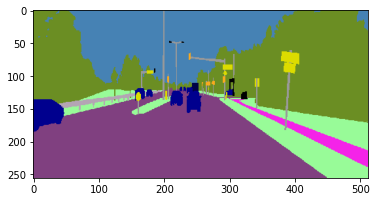

Test set Number:  1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.16395437102933613
Dice:  0.21569265167328563


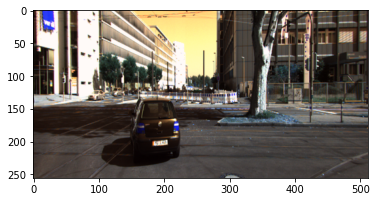

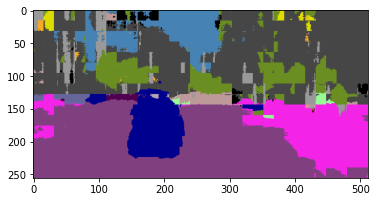

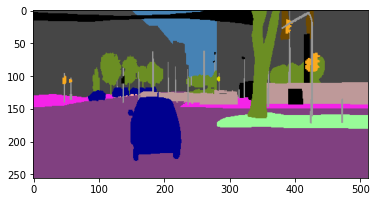

Test set Number:  2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.4302027937450505
Dice:  0.4875077439789489


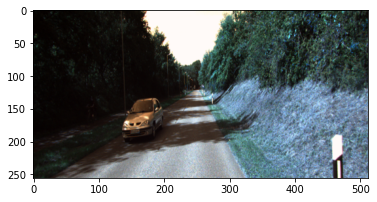

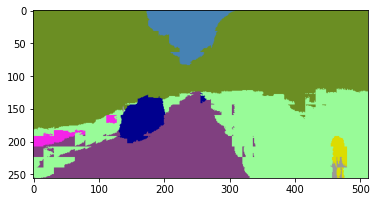

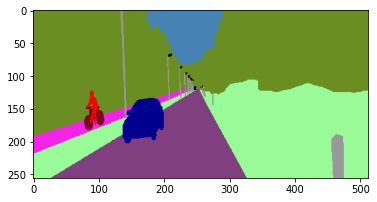

Test set Number:  3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.480692582725838
Dice:  0.5609770772176007


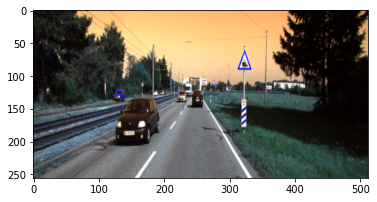

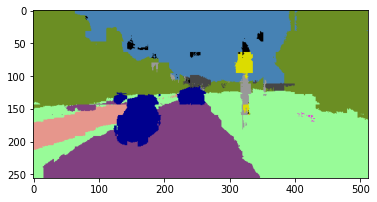

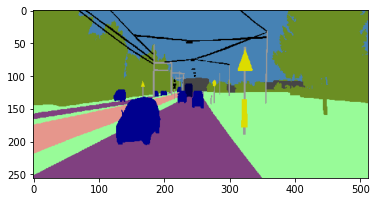

Test set Number:  4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.558094593113312
Dice:  0.633653204353108


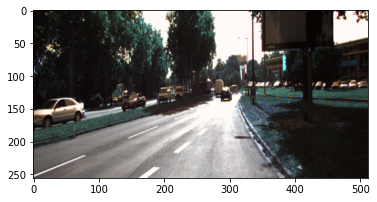

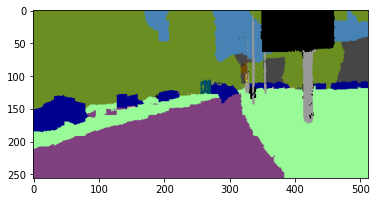

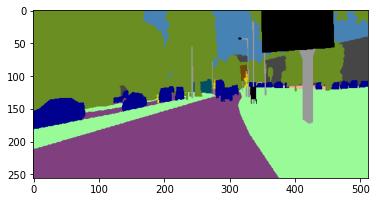

Test set Number:  5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.32771281793950396
Dice:  0.3655345298864862


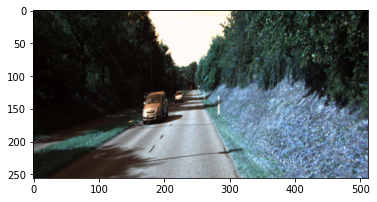

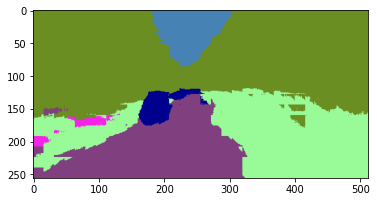

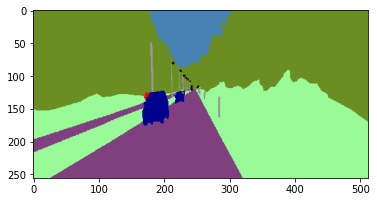

Test set Number:  6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.20680618190206435
Dice:  0.2630828931842847


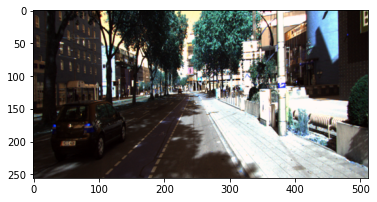

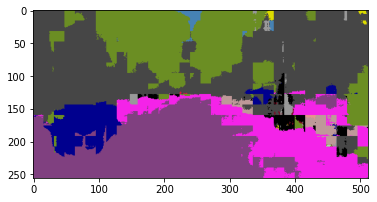

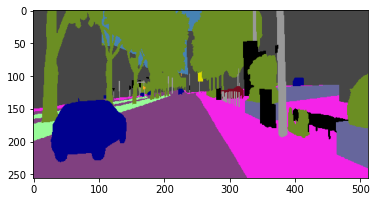

Test set Number:  7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.30699851239735787
Dice:  0.38566679687995015


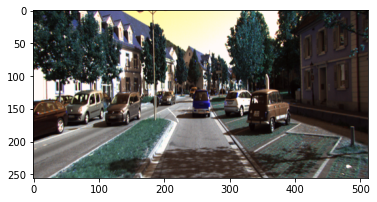

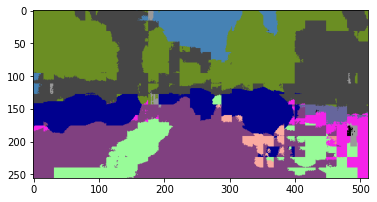

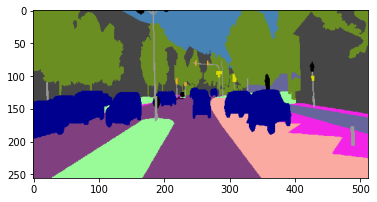

Test set Number:  8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.36153677072828555
Dice:  0.4056605843911772


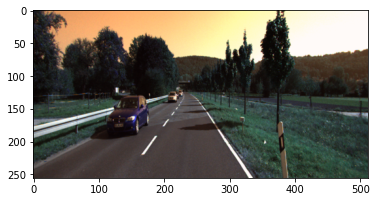

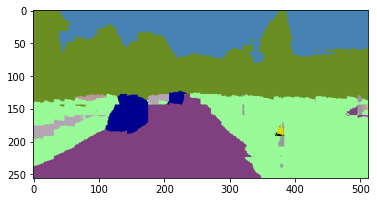

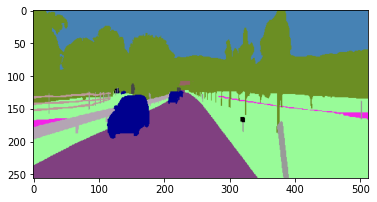

Test set Number:  9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.16616832804771853
Dice:  0.20437211327839633


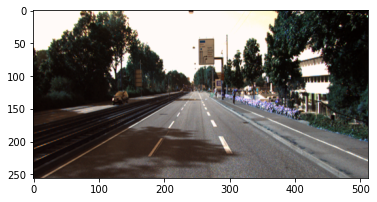

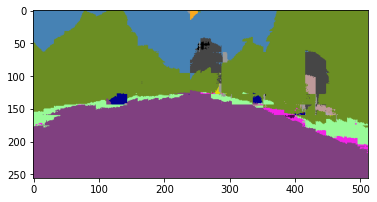

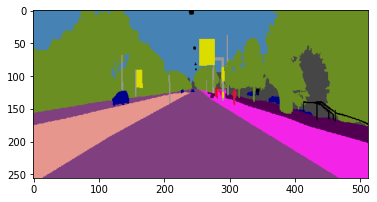

Test set Number:  10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.30941439842409657
Dice:  0.35566833239236034


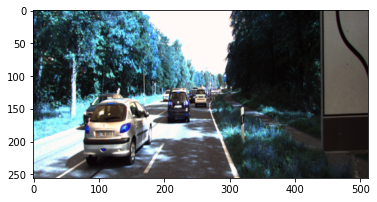

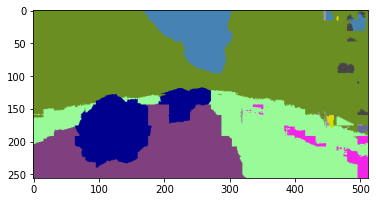

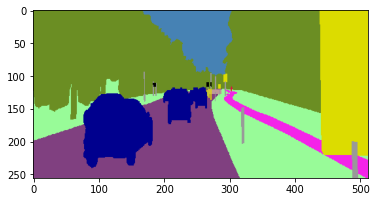

Test set Number:  11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.16434791265206036
Dice:  0.213228998988609


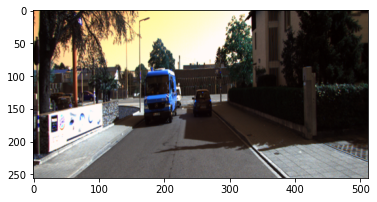

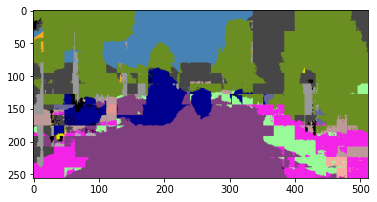

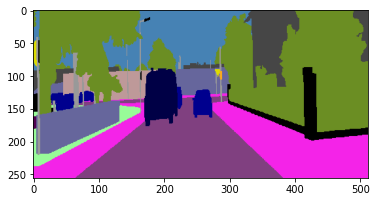

Test set Number:  12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.387273178641238
Dice:  0.43556686956902546


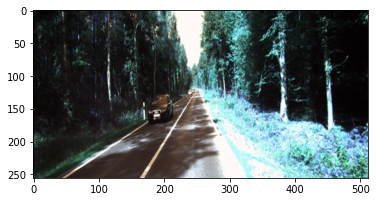

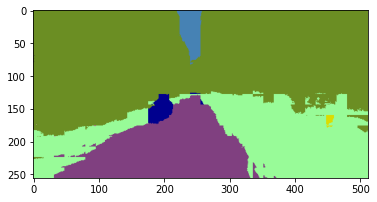

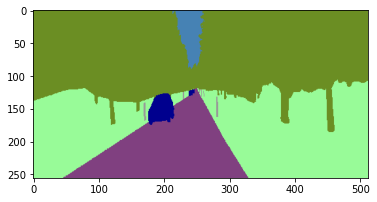

Test set Number:  13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.33174588345034284
Dice:  0.4039578869473812


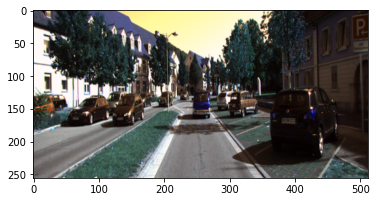

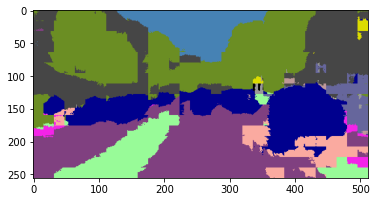

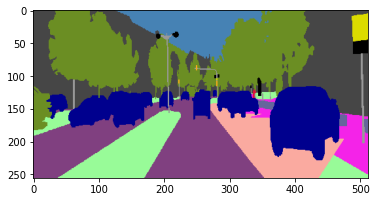

Test set Number:  14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.24364473667441405
Dice:  0.32128596644451046


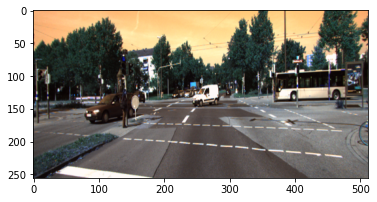

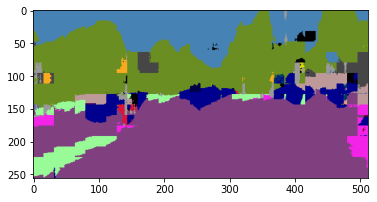

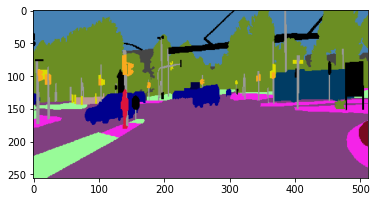

Test set Number:  15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.3371714156819543
Dice:  0.3889251375256572


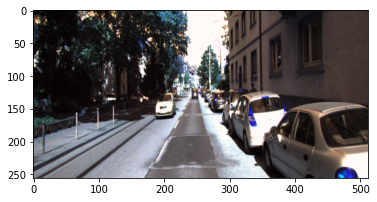

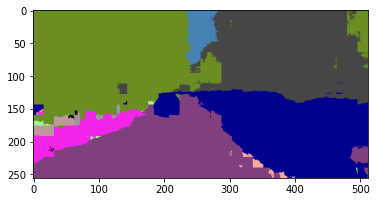

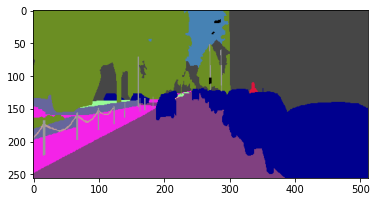

Test set Number:  16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.44335624004307006
Dice:  0.5214470961050112


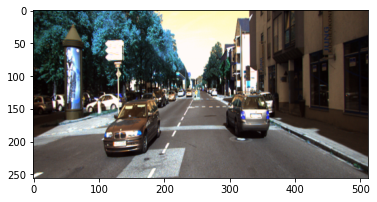

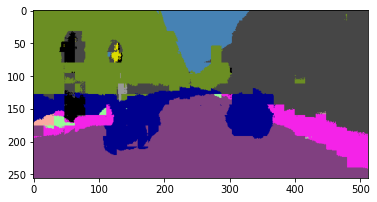

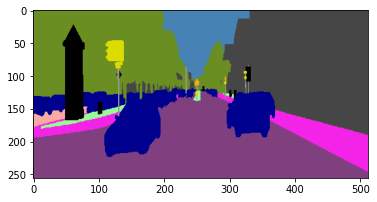

Test set Number:  17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.26893518653329057
Dice:  0.340992803263865


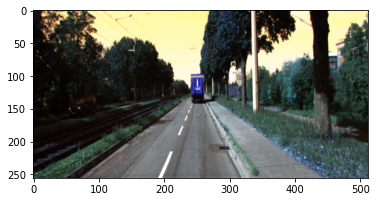

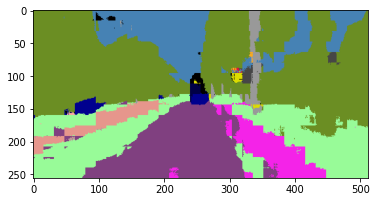

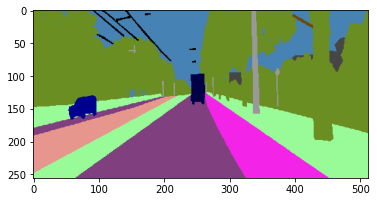

Test set Number:  18
IoU:  0.33603373597090974
Dice:  0.4106748131969363


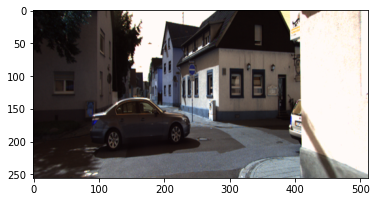

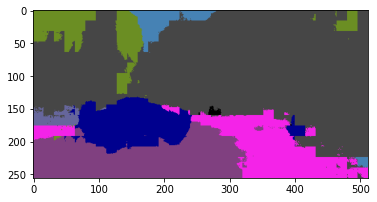

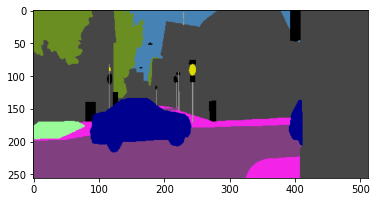

Test set Number:  19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.45357700333428064
Dice:  0.497912989243278


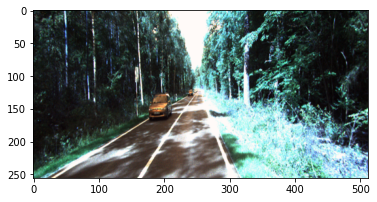

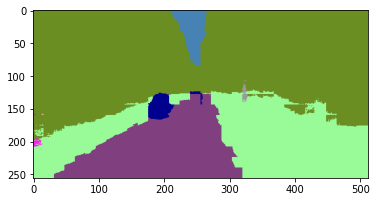

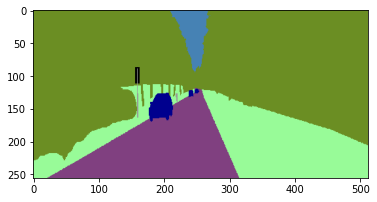

Test set Number:  20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.22430682276647657
Dice:  0.2627560128761261


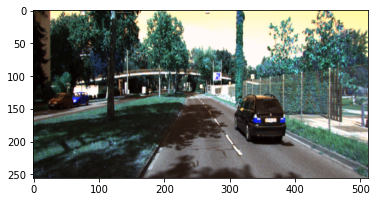

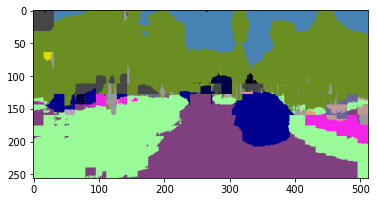

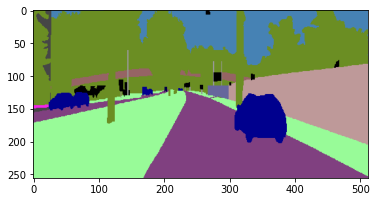

Test set Number:  21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.49505334557847913
Dice:  0.5452795421055631


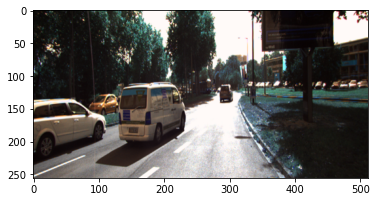

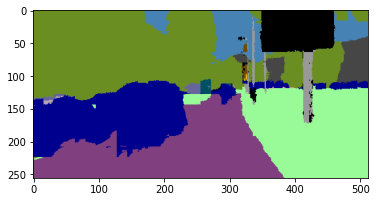

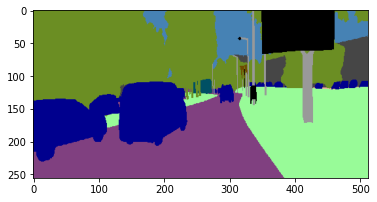

Test set Number:  22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.27982476478884394
Dice:  0.3451869345183699


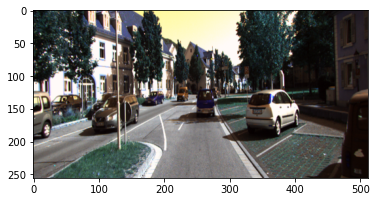

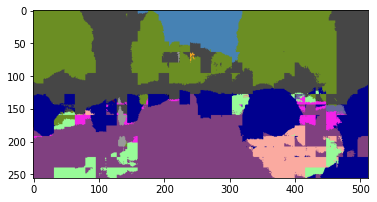

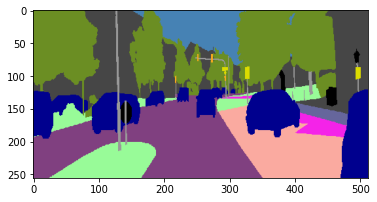

Test set Number:  23


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.2538665278997274
Dice:  0.32608584871224455


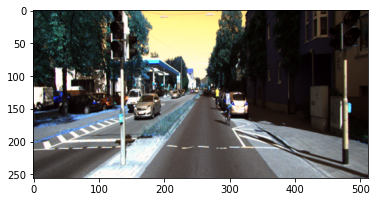

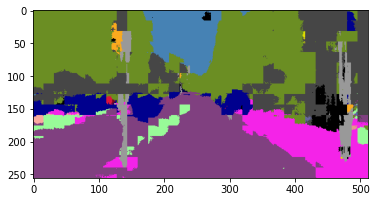

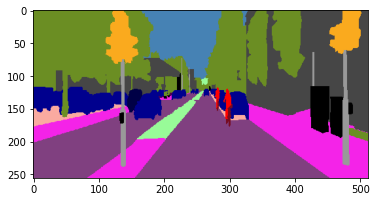

Test set Number:  24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.2850189576481091
Dice:  0.342543047549985


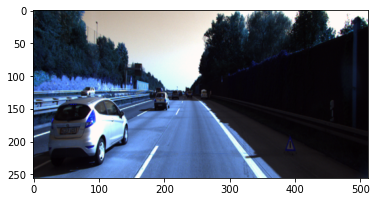

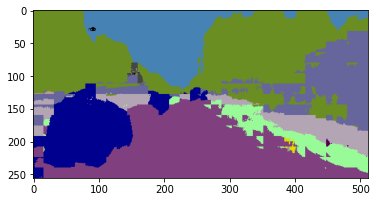

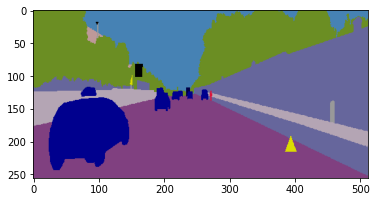

Test set Number:  25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.06177069300187014
Dice:  0.07592515196681485


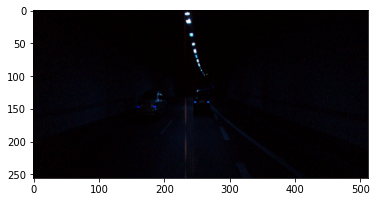

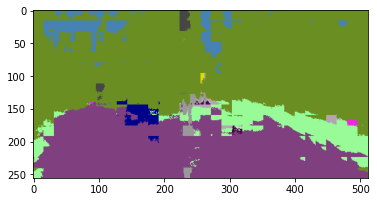

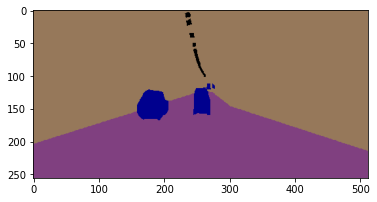

Test set Number:  26
IoU:  0.3742639293547273
Dice:  0.4288261269461293


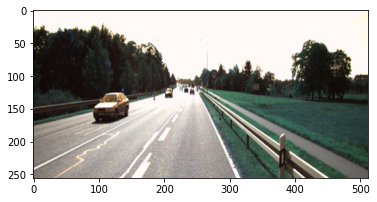

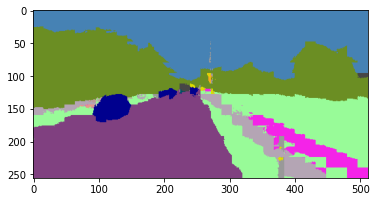

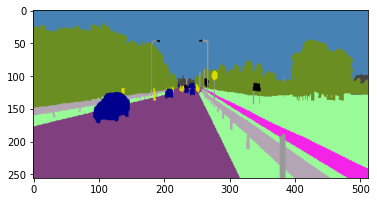

Test set Number:  27


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.2424309001515683
Dice:  0.3178963208223133


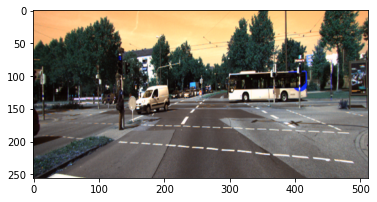

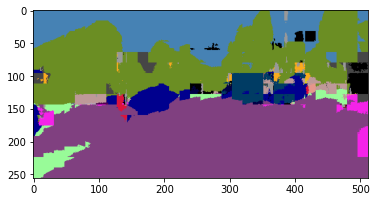

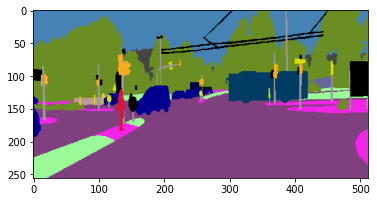

Test set Number:  28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.2476639916627642
Dice:  0.2975545443083053


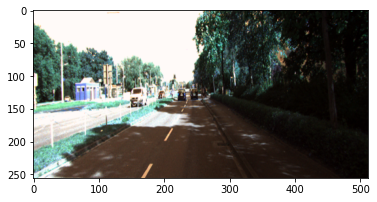

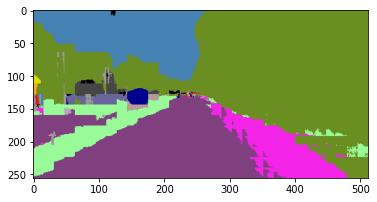

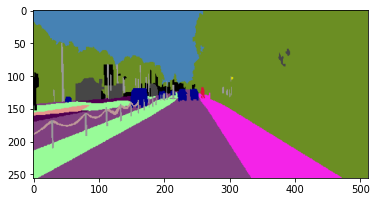

Test set Number:  29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IoU:  0.3577634232905005
Dice:  0.44285500528200034


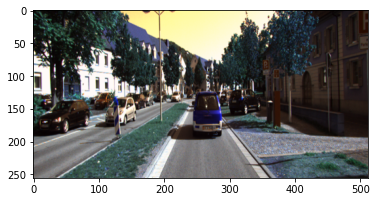

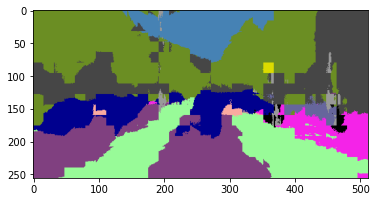

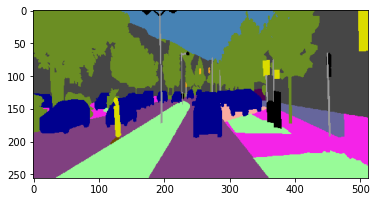

In [11]:
import numpy as np
#Map the labels to colors and display the results
def get_mean_iou(conf_mat, multiplier=1.0):
  cm = conf_mat.copy()
  np.fill_diagonal(cm, np.diag(cm) * multiplier)
  inter = np.diag(cm)
  gt_set = cm.sum(axis=1)
  pred_set = cm.sum(axis=0)
  union_set =  gt_set + pred_set - inter
  iou = inter.astype(float) / union_set
  mean_iou = np.nanmean(iou)
  return mean_iou


def decode_segmap(image, nc=35):
   
  label_colors = np.array([(  0,  0,  0),
               (  0,  0,  0) , (  0,  0,  0) , (  0,  0,  0), (  0,  0,  0), (111, 74,  0), ( 81,  0, 81), (128, 64,128), (244, 35,232), (250,170,160),
               (230,150,140),  ( 70, 70, 70), (102,102,156), (190,153,153), (180,165,180), (150,100,100), (150,120, 90),(153,153,153), (153,153,153),
               (250,170, 30), (220,220,  0), (107,142, 35), (152,251,152), ( 70,130,180), (220, 20, 60) , (255,  0,  0), ( 0, 0,142), (0, 0,70), (0, 60,100),
               (  0,  0, 90), (  0,  0,110), (  0, 80,100), (  0,  0,230), (119, 11, 32), (0,  0,142)])
 
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
     
  rgb = np.stack([r, g, b], axis=2)
  return rgb

with torch.no_grad():
  for k, dat in enumerate(testImages):
    inputs, labels = dat
    print("Test set Number: ", k)
    outputs = fcn16(inputs)
    pred = torch.argmax(outputs[0].squeeze(), dim=0).detach().numpy()
    gt = labels[0]

    #Calculate IoU
    preds = torch.argmax(outputs, dim=1).detach().numpy()
    groundTruth = labels.detach().numpy()
    conf_mat = confusion_matrix(y_pred=preds.flatten(), y_true=groundTruth.flatten(), labels=list(range(35)))
    IoU = get_mean_iou(conf_mat)
    Dice = get_mean_iou(conf_mat ,multiplier=2.0)
    print("IoU: ",IoU)
    print("Dice: ", Dice)

    unorm = UnNormalize(mean = [0.35675976, 0.37380189, 0.3764753], std = [0.32064945, 0.32098866, 0.32325324])
    img = unorm(inputs)

    plt.imshow(img[0].permute(1, 2, 0))
    plt.show()
    segmentation = decode_segmap(pred)
    gt_colored = decode_segmap(gt)
    plt.imshow(segmentation)
    plt.show()
    plt.imshow(gt_colored)
    plt.show()
